# **1. Importing the unimputed dataset**


In [73]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [66]:
data = pd.read_csv("readyForImpute.csv").drop("Unnamed: 0", axis=1)

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27538 entries, 0 to 27537
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quarter              27538 non-null  int64  
 1   Year                 27538 non-null  int64  
 2   District             27538 non-null  object 
 3   Price (billion VND)  27538 non-null  float64
 4   Area (m2)            26897 non-null  float64
 5   Property Type        27538 non-null  object 
 6   Floors               14936 non-null  float64
 7   Bathrooms            14163 non-null  float64
 8   Entrance (m2)        12209 non-null  float64
 9   Bedrooms             15707 non-null  float64
 10  Living Rooms         13190 non-null  float64
 11  Law Document         27538 non-null  object 
dtypes: float64(7), int64(2), object(3)
memory usage: 2.5+ MB


# **2. Defining methods to detect multicollinearity**


In [70]:
def numerical_convert(data: pd.DataFrame, categorical_encoder) -> any:
    """ Return the converted DataFrame and the transformation dictionary """
    transform_dict = dict()
    converted_data = data.copy()
    object_cols = data.select_dtypes(include=["object"]).columns
    for col in object_cols:
        converted_data[col] = categorical_encoder.fit_transform(data[[col]])
        transform_dict[col] = list(zip(converted_data[col].unique(), data[col].unique()))
    return converted_data, transform_dict
    
def correlation_map(converted_data: pd.DataFrame) -> None:
    """ Showing the correlation between any 2 variables """
    corr_matrix = converted_data.corr()
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5, linecolor="black")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.title("Correlations between every 2 fields", fontweight="bold")
    return

def VIF_values(converted_data: pd.DataFrame):
    """ Showing the Variance Inflation Factor (VIF) for each field """
    X = add_constant(converted_data)
    vif_df = pd.DataFrame()
    vif_df["Fields"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

In [89]:
converted_data, transformation = numerical_convert(data=data, categorical_encoder= OrdinalEncoder())
# A complete-case dataset
converted_completed_data = converted_data.dropna(ignore_index=True)

## **2.1. Correlation matrix visualized for unimputed dataset**


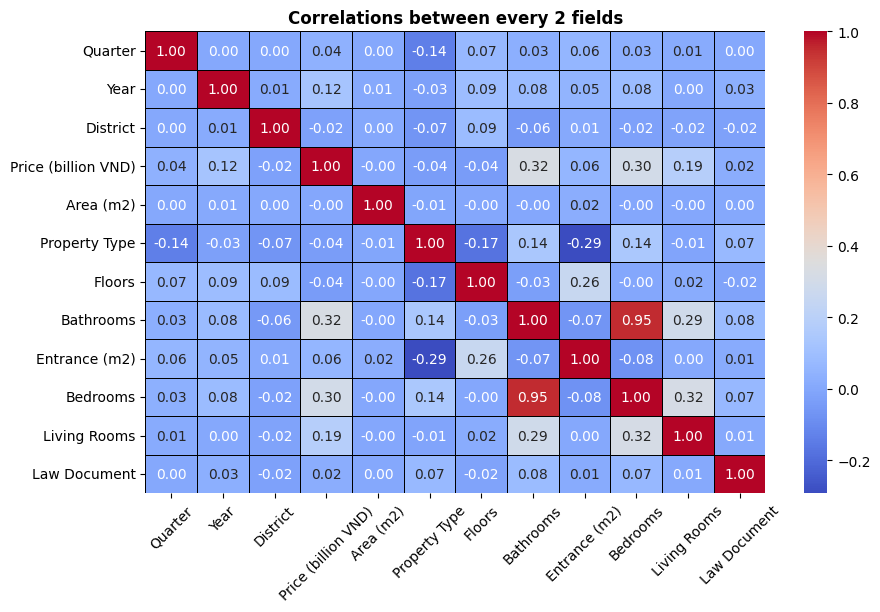

In [76]:
# Correlation between any 2 fields
correlation_map(converted_data)

## **2.2. Correlation matrix visualized for the Complete Case Dataset**


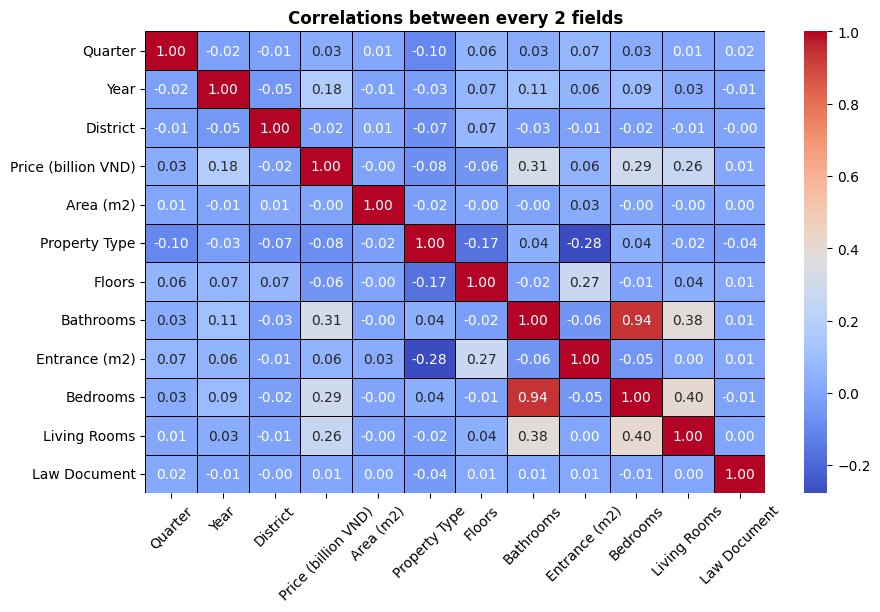

In [77]:
correlation_map(converted_completed_data)

## **2.3. The Variance Inflation Factor (VIF) for each field in the Complete Case Dataset**


In [79]:
print(VIF_values(converted_completed_data))

                 Fields           VIF
0                 const  2.135780e+06
1               Quarter  1.016759e+00
2                  Year  1.052824e+00
3              District  1.016324e+00
4   Price (billion VND)  1.185725e+00
5             Area (m2)  1.001286e+00
6         Property Type  1.118435e+00
7                Floors  1.113453e+00
8             Bathrooms  8.547377e+00
9         Entrance (m2)  1.162226e+00
10             Bedrooms  8.622883e+00
11         Living Rooms  1.235060e+00
12         Law Document  1.003200e+00


# **3. Checking for multicollinearity among the predictors**

_These predictors are specified in the **preds_dict** of the <code>main.py</code> file._


In [80]:
predictors_data = converted_data[["Quarter", "Year", "District", "Price (billion VND)", "Property Type", "Law Document"]]
predictors_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27538 entries, 0 to 27537
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quarter              27538 non-null  int64  
 1   Year                 27538 non-null  int64  
 2   District             27538 non-null  float64
 3   Price (billion VND)  27538 non-null  float64
 4   Property Type        27538 non-null  float64
 5   Law Document         27538 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3 MB


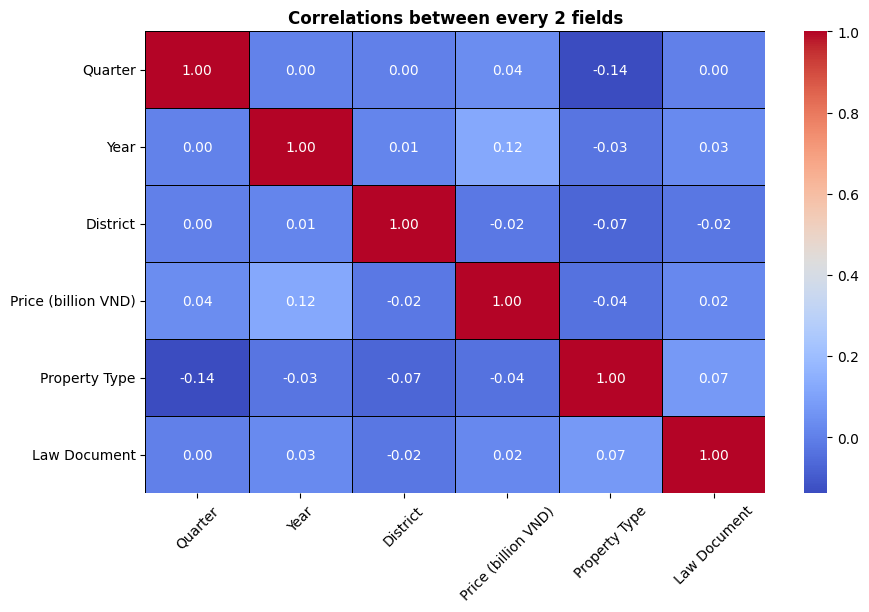

In [81]:
correlation_map(predictors_data)

In [82]:
VIF_values(predictors_data)

,Fields,VIF
0,const,1.689882e+06
1,Quarter,1.021035e+00
2,Year,1.016510e+00
3,District,1.006275e+00
4,Price (billion VND),1.018479e+00
5,Property Type,1.032299e+00
6,Law Document,1.007225e+00


# **4. Scaling the data**

_Might be necessary for different imputation strategies, the current strategy used here is "mode"._


In [94]:
converted_data.head()

,Quarter,Year,District,Price (billion VND),Area (m2),Property Type,Floors,Bathrooms,Entrance (m2),Bedrooms,Living Rooms,Law Document
0,4,2024,12.0,6.200,133.1,1.0,18.0,3.0,2.0,4.0,1.0,1.0
1,3,2024,16.0,16.450,200.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0
2,3,2024,27.0,13.793,144.0,1.0,NaN,3.0,NaN,3.0,1.0,1.0
3,3,2024,22.0,5.277,80.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0
4,3,2024,22.0,4.300,80.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0


In [95]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(converted_data)
scaled_df = pd.DataFrame(scaled_data, columns = converted_data.columns)

In [96]:
scaled_df.head()

,Quarter,Year,District,Price (billion VND),Area (m2),Property Type,Floors,Bathrooms,Entrance (m2),Bedrooms,Living Rooms,Law Document
0,2.0,1.0,0.200000,0.130435,1.168519,-0.5,6.5,0.0,-0.518519,0.5,0.0,0.0
1,1.0,1.0,0.466667,1.244565,2.407407,-0.5,NaN,NaN,NaN,NaN,NaN,-1.0
2,1.0,1.0,1.200000,0.955761,1.370370,-0.5,NaN,0.0,NaN,0.0,0.0,0.0
3,1.0,1.0,0.866667,0.030109,0.185185,-0.5,NaN,NaN,NaN,NaN,NaN,-1.0
4,1.0,1.0,0.866667,-0.076087,0.185185,-0.5,NaN,NaN,NaN,NaN,NaN,-1.0


In [99]:
unscaled_data = scaler.inverse_transform(scaled_df)
unscaled_df = pd.DataFrame(unscaled_data, columns = scaled_df.columns)

In [100]:
unscaled_df.head()

,Quarter,Year,District,Price (billion VND),Area (m2),Property Type,Floors,Bathrooms,Entrance (m2),Bedrooms,Living Rooms,Law Document
0,4.0,2024.0,12.0,6.200,133.1,1.0,18.0,3.0,2.0,4.0,1.0,1.0
1,3.0,2024.0,16.0,16.450,200.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0
2,3.0,2024.0,27.0,13.793,144.0,1.0,NaN,3.0,NaN,3.0,1.0,1.0
3,3.0,2024.0,22.0,5.277,80.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0
4,3.0,2024.0,22.0,4.300,80.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0


# **5. Checking the ModeImputedData for correlation**


In [102]:
mode_imputed = pd.read_csv("ModeImputedData.csv").drop("Unnamed: 0", axis=1)

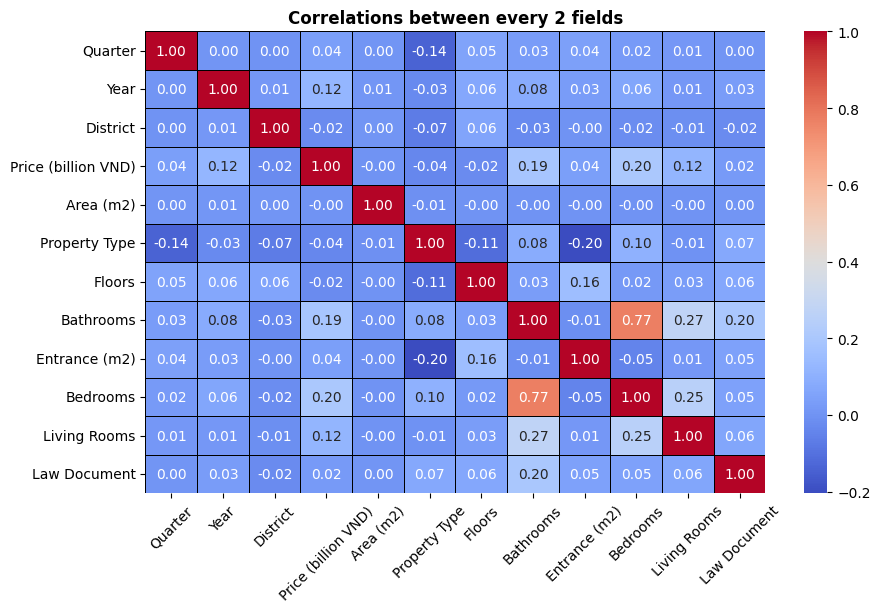

In [104]:
numerical_mode = numerical_convert(mode_imputed, categorical_encoder= OrdinalEncoder())[0]
correlation_map(numerical_mode)

In [105]:
print(VIF_values(numerical_mode))

                 Fields           VIF
0                 const  1.702161e+06
1               Quarter  1.023829e+00
2                  Year  1.024063e+00
3              District  1.009432e+00
4   Price (billion VND)  1.071572e+00
5             Area (m2)  1.000221e+00
6         Property Type  1.097931e+00
7                Floors  1.047926e+00
8             Bathrooms  2.673419e+00
9         Entrance (m2)  1.070204e+00
10             Bedrooms  2.583079e+00
11         Living Rooms  1.091983e+00
12         Law Document  1.083201e+00


## The heatmap and VIF values have shown that:

- There is **no severe multicollinearity** in our dataset after imputations.
- However, there is **collinearity** between the <code>Bathrooms</code> and <code>Bedrooms</code>.
